In [8]:
# %%
import os, glob, re
from typing import Dict
import pyshark
import asyncio
import nest_asyncio
import pandas as pd
import pickle
from pathlib import Path

# Apply the patch
nest_asyncio.apply()

_ROUNDS_RE = re.compile(
    r"""
        Round\s+(\d+),\s+time\s+for\s+\S+\s+is\s+
        ([0-9]*\.?[0-9]+)
    """,
    re.VERBOSE,
)


# remove a trailing «-<letters+digits>»  (e.g. -eth0, -wlan1, -lo)
_IFACE_TAIL = re.compile(r"-[a-zA-Z]+[0-9]*$")


import os
import subprocess

def get_flow_stats(pcap_path: str) -> pd.DataFrame:
    """
    Ritorna un DataFrame aggregato per flusso (ip_src, ip_dst, bytes).
    Gestisce intestazioni con il punto (es. ip.src) rinominandole con _.
    """
    if not os.path.isfile(pcap_path):
        print(f"[warn] PCAP file not found: {pcap_path}")
        return pd.DataFrame(columns=["ip_src", "ip_dst", "bytes"])

    try:
        # 1. carica il CSV
        df = pd.read_csv(pcap_path, na_filter=False)        # mantieni stringhe vuote

        # 2. uniforma i nomi colonna: ip.src ➜ ip_src, ip.dst ➜ ip_dst
        df.columns = [c.replace(".", "_") for c in df.columns]

        required = {"ip_src", "ip_dst", "frame_len"}
        if not required.issubset(df.columns):
            raise ValueError(f"Mancano colonne: {required - set(df.columns)}")

        # 3. filtra solo traffico verso 10.0.0.100 da sorgenti diverse
        mask = (df["ip_dst"] == "10.0.0.100") & (df["ip_src"] != "10.0.0.100")
        df_filtered = df.loc[mask, ["ip_src", "ip_dst", "frame_len"]]

        # 4. aggrega per flusso e rinomina
        flows = (
            df_filtered.groupby(["ip_src", "ip_dst"], as_index=False)["frame_len"]
            .sum()
            .rename(columns={"frame_len": "bytes"})
        )
        return flows

    except Exception as e:
        print(f"[error] Failed to process PCAP {pcap_path}: {e}")
        return pd.DataFrame(columns=["ip_src", "ip_dst", "bytes"])

def _base_stem(path: str) -> str:
    """Stem without interface suffix."""
    stem = os.path.splitext(os.path.basename(path))[0]
    return _IFACE_TAIL.sub("", stem)

def _round_stats(log_path: str) -> tuple[int, int]:
    txt = open(log_path, encoding="utf-8").read()
    ids = [int(m.group(1)) for m in _ROUNDS_RE.finditer(txt)]
    return len(set(ids)), len(ids), ids

def analyze_federated_learning_data(folder: str) -> Dict[str, Dict]:
    pcaps = glob.glob(os.path.join(folder, "*ps_fed_opt0*.csv"))
    logs  = glob.glob(os.path.join(folder, "*ps_fed_opt0*.log"))

    # index logs by *base* stem
    logs_by_base = { _base_stem(p): p for p in logs }

    results = {}
    for pcap in pcaps:
        base = _base_stem(pcap)
        log  = logs_by_base.get(base)

        if log is None:
            print(f"[warn] n_msgsNo matching log for {pcap}")
            continue

        n_rounds, n_msgs,ids = _round_stats(log)
        dict_flow_B = get_flow_stats(pcap)

        results = {
            "rounds_completed": n_rounds,
            "client_messages":  n_msgs,
            "dict_flow_B": dict_flow_B,
            "ids": ids,
            "log": log,
            "pcap": pcap,
        }

    return results

# %%
base_path = "/home/antoniob/FederNet/src/output"

df_list_sync = [
    {
    "file_path":"config_preliminary_test/2025-05-27-20-48-47_mqtt_fed_opt_C10_wifi_80211ac_rpi4_FedAvgN_A10_CSFalse",
    "model":"FedAvg",
    "protocol":"MQTT",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
    # "file_path":"config_cs_iid/2025-06-23-11-06-51_mqtt_fed_opt_C10_wifi_80211ac_rpi4_FedAvgN_A10_CSTrue" ,
    # "model":"FedAvg",
    # "protocol":"MQTT",
    # "data_distribution":"iid",
    # "client_selection":"True",
    # },{    
    "file_path":"config_preliminary_test/2025-05-28-14-55-27_mqtt_fed_opt_C10_wifi_80211ac_rpi4_FedAvgN_A0.5_CSTrue",
    "model":"FedAvg",
    "protocol":"MQTT",
    "data_distribution":"non-iid",
    "client_selection":"True",
    },{
    "file_path":"config_preliminary_test/2025-05-30-17-43-09_mqtt_fed_opt_C10_wifi_80211ac_rpi4_FedAvgN_A0.5_CSFalse",
    "model":"FedAvg",
    "protocol":"MQTT",
    "data_distribution":"non-iid",
    "client_selection":"False",
    },{
    "file_path":"config_preliminary_test/2025-05-29-00-36-48_mqtt_fed_opt_C10_wifi_80211ac_rpi4_SCAFFOLD_A10_CSFalse",
    "model":"SCAFFOLD",
    "protocol":"MQTT",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
    # "file_path":"config_cs_iid/2025-06-24-11-02-34_mqtt_fed_opt_C10_wifi_80211ac_rpi4_SCAFFOLD_A10_CSTrue",
    # "model":"SCAFFOLD",
    # "protocol":"MQTT",
    # "data_distribution":"iid",
    # "client_selection":"True",
    # },{
    "file_path":"config_preliminary_test/2025-05-29-12-16-54_mqtt_fed_opt_C10_wifi_80211ac_rpi4_SCAFFOLD_A0.5_CSTrue",
    "model":"SCAFFOLD",
    "protocol":"MQTT",
    "data_distribution":"non-iid",
    "client_selection":"True",
    },{
    "file_path":"config_preliminary_test/2025-05-31-03-15-34_mqtt_fed_opt_C10_wifi_80211ac_rpi4_SCAFFOLD_A0.5_CSFalse",
    "model":"SCAFFOLD",
    "protocol":"MQTT",
    "data_distribution":"non-iid",
    "client_selection":"False",
    },{
    "file_path":"config_grpc/2025-06-05-16-04-12_grpc_fed_opt_C10_wifi_80211ac_rpi4_FedAvgN_A10_CSFalse",
    "model":"FedAvg",
    "protocol":"gRPC",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
    # "file_path":"config_cs_iid/2025-06-21-09-48-06_grpc_fed_opt_C10_wifi_80211ac_intel_nuc8_FedAvgN_A10_CSTrue",
    # "model":"FedAvg",
    # "protocol":"gRPC",
    # "data_distribution":"iid",
    # "client_selection":"True",
    # },{
    "file_path":"config_grpc/2025-06-10-01-33-31_grpc_fed_opt_C10_wifi_80211ac_rpi4_FedAvgN_A0.5_CSTrue",
    "model":"FedAvg",
    "protocol":"gRPC",
    "data_distribution":"non-iid",
    "client_selection":"True",
    },{
    "file_path":"config_grpc/2025-06-19-15-25-05_grpc_fed_opt_C10_wifi_80211ac_rpi4_FedAvgN_A0.5_CSFalse",
    "model":"FedAvg",
    "protocol":"gRPC",
    "data_distribution":"non-iid",
    "client_selection":"False",
    },{
    "file_path":"config_grpc/2025-06-06-10-44-39_grpc_fed_opt_C10_wifi_80211ac_rpi4_SCAFFOLD_A10_CSFalse",
    "model":"SCAFFOLD",
    "protocol":"gRPC",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
    # "file_path":"config_cs_iid/2025-06-20-13-04-45_grpc_fed_opt_C10_wifi_80211ac_intel_nuc8_SCAFFOLD_A10_CSTrue",
    # "model":"SCAFFOLD",
    # "protocol":"gRPC",
    # "data_distribution":"iid",
    # "client_selection":"True",
    # },{
    "file_path":"config_grpc/2025-06-10-15-05-02_grpc_fed_opt_C10_wifi_80211ac_rpi4_SCAFFOLD_A0.5_CSTrue",
    "model":"SCAFFOLD",
    "protocol":"gRPC",
    "data_distribution":"non-iid",
    "client_selection":"True",
    },{
    "file_path":"config_grpc/2025-06-09-16-02-38_grpc_fed_opt_C10_wifi_80211ac_rpi4_SCAFFOLD_A0.5_CSFalse",
    "model":"SCAFFOLD",
    "protocol":"gRPC",
    "data_distribution":"non-iid",
    "client_selection":"False",
    }
]


results_by_folder: Dict[str, Dict] = {}

for entry in df_list_sync:
    full_path = os.path.join(base_path, entry["file_path"])
    entry["full_path"] = full_path

    flows_dict = analyze_federated_learning_data(full_path)  # <- usa get_flow_stats

            
            
    entry["flows"] = flows_dict['dict_flow_B']
    entry['rounds_details'] = flows_dict['ids']
    entry["rounds_completed"] = flows_dict['rounds_completed']
    entry["client_messages"] = flows_dict['client_messages']
    entry["log"] = flows_dict['log']
    entry["pcap"] = flows_dict['pcap']

    results_by_folder[entry["file_path"]] = entry
    
# ---------------------------------------------------------------------------
pkl_path = Path(base_path) / "sync_analysis.pkl"
with open(pkl_path, "wb") as fout:
    pickle.dump(df_list_sync, fout)

print(f"[info] Analisi completata. Risultati salvati in: {pkl_path}")

for d in df_list_sync:                     # each element is a dict-like record
    d['sum_bytes'] = d['flows']['bytes'].sum()
    d['per_round_bytes'] = d['sum_bytes'] / d['rounds_completed']
    d['per_message_bytes'] = d['sum_bytes'] / d['client_messages']
    d['overhead'] = d['per_message_bytes'] / 962628
    d['overhead_perc'] = (d['overhead'] -1)* 100

df = pd.DataFrame(df_list_sync)

[info] Analisi completata. Risultati salvati in: /home/antoniob/FederNet/src/output/sync_analysis.pkl


In [9]:
df

,file_path,model,protocol,data_distribution,client_selection,full_path,flows,rounds_details,rounds_completed,client_messages,log,pcap,sum_bytes,per_round_bytes,per_message_bytes,overhead,overhead_perc
0,config_preliminary_test/2025-05-27-20-48-47_mq...,FedAvg,MQTT,iid,False,/home/antoniob/FederNet/src/output/config_prel...,ip_src ip_dst bytes 0 10.0....,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, ...",51,506,/home/antoniob/FederNet/src/output/config_prel...,/home/antoniob/FederNet/src/output/config_prel...,539744677,1.058323e+07,1.066689e+06,1.108101,10.810104
1,config_preliminary_test/2025-05-28-14-55-27_mq...,FedAvg,MQTT,non-iid,True,/home/antoniob/FederNet/src/output/config_prel...,ip_src ip_dst bytes 0 10.0....,"[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, ...",30,150,/home/antoniob/FederNet/src/output/config_prel...,/home/antoniob/FederNet/src/output/config_prel...,162079857,5.402662e+06,1.080532e+06,1.122482,12.248177
2,config_preliminary_test/2025-05-30-17-43-09_mq...,FedAvg,MQTT,non-iid,False,/home/antoniob/FederNet/src/output/config_prel...,ip_src ip_dst bytes 0 10.0....,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, ...",30,300,/home/antoniob/FederNet/src/output/config_prel...,/home/antoniob/FederNet/src/output/config_prel...,320413348,1.068044e+07,1.068044e+06,1.109509,10.950907
3,config_preliminary_test/2025-05-29-00-36-48_mq...,SCAFFOLD,MQTT,iid,False,/home/antoniob/FederNet/src/output/config_prel...,ip_src ip_dst bytes 0 10.0....,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, ...",30,300,/home/antoniob/FederNet/src/output/config_prel...,/home/antoniob/FederNet/src/output/config_prel...,682895383,2.276318e+07,2.276318e+06,2.364691,136.469118
4,config_preliminary_test/2025-05-29-12-16-54_mq...,SCAFFOLD,MQTT,non-iid,True,/home/antoniob/FederNet/src/output/config_prel...,ip_src ip_dst bytes 0 10.0....,"[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, ...",30,150,/home/antoniob/FederNet/src/output/config_prel...,/home/antoniob/FederNet/src/output/config_prel...,343362884,1.144543e+07,2.289086e+06,2.377955,137.795482
5,config_preliminary_test/2025-05-31-03-15-34_mq...,SCAFFOLD,MQTT,non-iid,False,/home/antoniob/FederNet/src/output/config_prel...,ip_src ip_dst bytes 0 10.0....,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, ...",30,300,/home/antoniob/FederNet/src/output/config_prel...,/home/antoniob/FederNet/src/output/config_prel...,681330829,2.271103e+07,2.271103e+06,2.359274,135.927353
6,config_grpc/2025-06-05-16-04-12_grpc_fed_opt_C...,FedAvg,gRPC,iid,False,/home/antoniob/FederNet/src/output/config_grpc...,ip_src ip_dst bytes 0 10.0....,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, ...",19,182,/home/antoniob/FederNet/src/output/config_grpc...,/home/antoniob/FederNet/src/output/config_grpc...,194948562,1.026045e+07,1.071146e+06,1.112731,11.273093
7,config_grpc/2025-06-10-01-33-31_grpc_fed_opt_C...,FedAvg,gRPC,non-iid,True,/home/antoniob/FederNet/src/output/config_grpc...,ip_src ip_dst bytes 0 10.0....,"[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, ...",27,135,/home/antoniob/FederNet/src/output/config_grpc...,/home/antoniob/FederNet/src/output/config_grpc...,146210483,5.415203e+06,1.083041e+06,1.125087,12.508738
8,config_grpc/2025-06-19-15-25-05_grpc_fed_opt_C...,FedAvg,gRPC,non-iid,False,/home/antoniob/FederNet/src/output/config_grpc...,ip_src ip_dst bytes 0 10.0....,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, ...",30,300,/home/antoniob/FederNet/src/output/config_grpc...,/home/antoniob/FederNet/src/output/config_grpc...,320574092,1.068580e+07,1.068580e+06,1.110066,11.006568
9,config_grpc/2025-06-06-10-44-39_grpc_fed_opt_C...,SCAFFOLD,gRPC,iid,False,/home/antoniob/FederNet/src/output/config_grpc...,ip_src ip_dst bytes 0 10.0....,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, ...",30,300,/home/antoniob/FederNet/src/output/config_grpc...,/home/antoniob/FederNet/src/output/config_grpc...,682070313,2.273568e+07,2.273568e+06,2.361834,136.183418


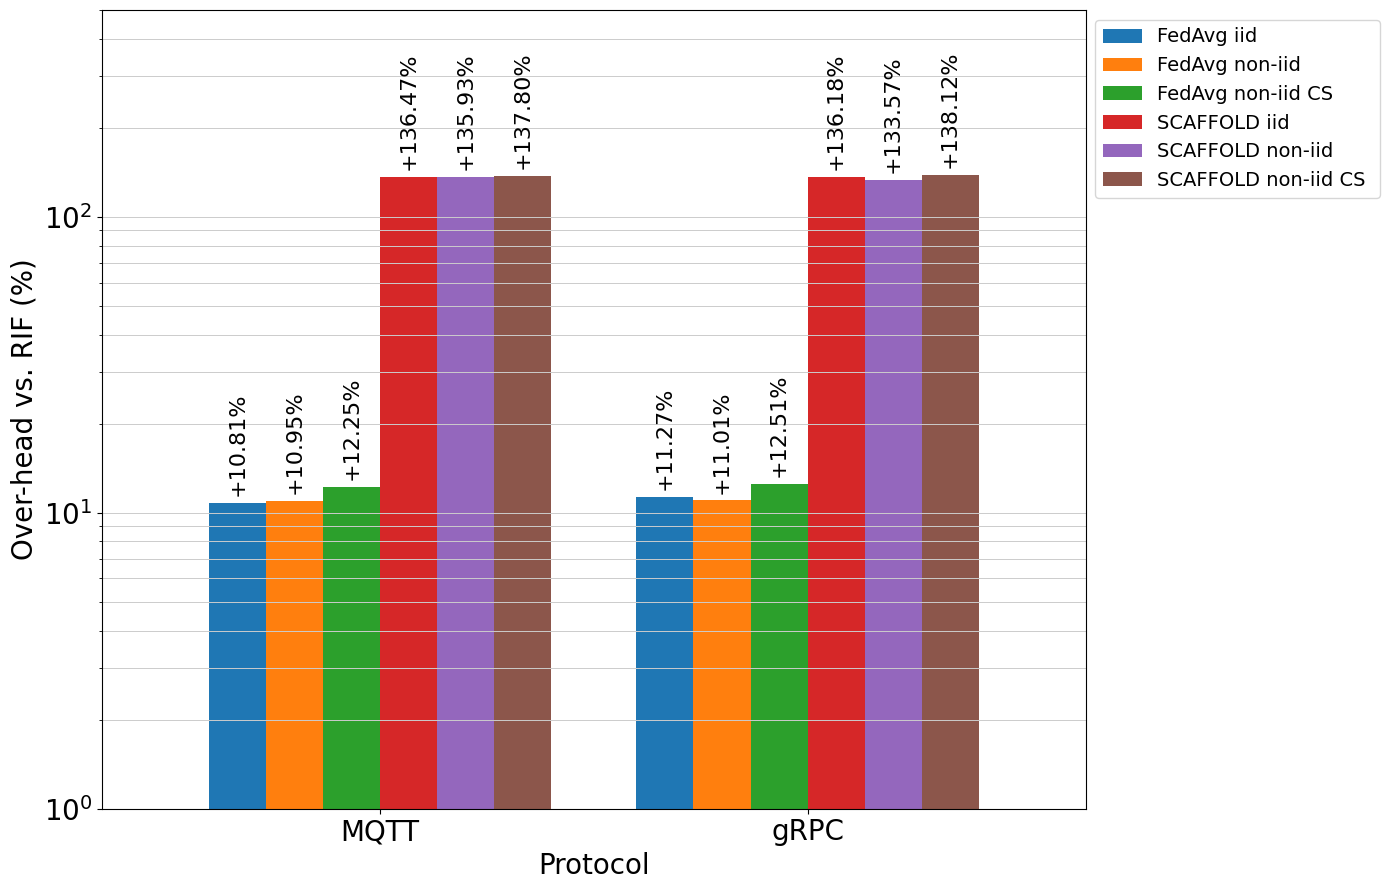

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# --------------------------------------------
# 1) sotto-bucket senza protocollo
# --------------------------------------------
df["subbucket"] = df.apply(
    lambda r: f"{r['model']} {r['data_distribution']} {'CS' if r['client_selection'] == 'True' else ''} ",
    axis=1
)

# --------------------------------------------
# 2) aggregazione e conversione in percentuale
#    (overhead fattoriale → delta %)
# --------------------------------------------
g = df.groupby(["protocol", "subbucket"])["overhead_perc"].mean()
# df_pct = (g - 1) * 100           # % rispetto al baseline
df_plot = g.unstack("subbucket")   # index = protocol, columns = subbucket

# --------------------------------------------
# 3) plot
# --------------------------------------------
fig, ax = plt.subplots(figsize=(14, 9))
bars = df_plot.plot(kind="bar", width=0.8, ax=ax)

# 3a) etichette + / - %
for container in bars.containers:
    labels = []
    for bar in container:
        v = bar.get_height()
        labels.append("" if np.isnan(v) else f"{'+' if v>=0 else ''}{v:.2f}%")
    ax.bar_label(container, labels=labels, label_type="edge",
                 fontsize=16, rotation=90, padding=5)

# 3b) asse Y symlog
ax.set_yscale("log")   # segmento lineare entro ±1 %
ax.set_ylim(1, 500)   
minor_ticks = [-50,-40,-30,-20,-10,-9,-8,-7,-6,-5,-4,-3,-2,
               2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,
               100,200,300,400,500,600,700,800,900]
ax.yaxis.set_minor_locator(FixedLocator(minor_ticks))

# 3c) estetica
plt.grid(axis="y", which="both", color="#cccccc", linestyle="-", linewidth=0.7)
plt.xticks(rotation=0, fontsize=20)      # i tick contengono già solo il protocollo
plt.yticks(fontsize=20)
plt.xlabel("Protocol", fontsize=20)
plt.ylabel("Over-head vs. RIF (%)", fontsize=20)

plt.legend(loc="upper left", bbox_to_anchor=(1, 1),
           fontsize=14, title="")        # solo sub-bucket
plt.tight_layout()
plt.show()


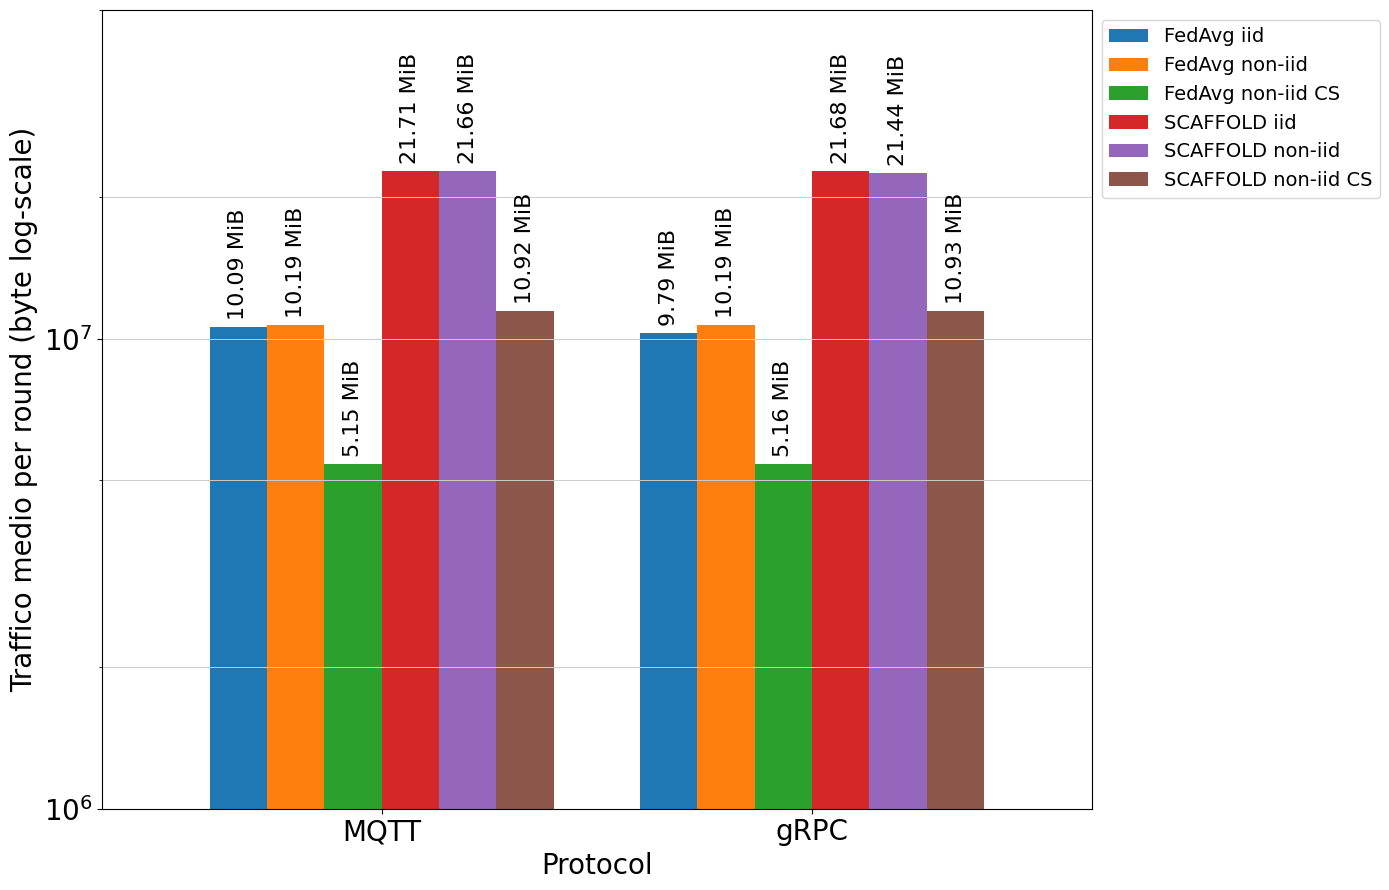

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# ------------------------------------------------------------------
# 1) sotto-bucket (senza protocollo nella stringa)
# ------------------------------------------------------------------
df["subbucket"] = (
    df.apply(
        lambda r: f"{r['model']} {r['data_distribution']} "
                  f"{'CS' if r['client_selection'] == 'True' else ''}".strip(),
        axis=1
    )
)

# ------------------------------------------------------------------
# 2) aggregazione (media per protocollo+sotto-bucket)
# ------------------------------------------------------------------
g = df.groupby(["protocol", "subbucket"])["per_round_bytes"].mean()
df_plot = g.unstack("subbucket")      # index = protocol, columns = subbucket

# ------------------------------------------------------------------
# 3) plot
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 9))
bars = df_plot.plot(kind="bar", width=0.8, ax=ax)

# ──────────────────────────────────────────────────────────────────
# 3a) etichette in B / KiB / MiB
# ──────────────────────────────────────────────────────────────────
def fmt_bytes(b):
    if np.isnan(b):
        return ""
    if b >= 1024**2:
        return f"{b/1024**2:.2f} MiB"
    if b >= 1024:
        return f"{b/1024:.2f} KiB"
    return f"{b:.0f} B"

for container in bars.containers:
    ax.bar_label(
        container,
        labels=[fmt_bytes(bar.get_height()) for bar in container],
        label_type="edge",
        fontsize=16,
        rotation=90,
        padding=5
    )

# ──────────────────────────────────────────────────────────────────
# 3b) asse Y symlog (byte)
# ──────────────────────────────────────────────────────────────────
ax.set_yscale("log")
ax.set_ylim(1_000_000, 50_000_000)      # (≈ 10 KB – 100 MB)
minor_ticks = [
    20_000, 50_000, 100_000, 200_000, 500_000,           # KiB region
    1_000_000, 2_000_000, 5_000_000,                     # MiB region
    10_000_000, 20_000_000, 50_000_000
]
ax.yaxis.set_minor_locator(FixedLocator(minor_ticks))

# ──────────────────────────────────────────────────────────────────
# 3c) estetica
# ──────────────────────────────────────────────────────────────────
plt.grid(axis="y", which="both", color="#cccccc", linestyle="-", linewidth=0.7)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Protocol", fontsize=20)
plt.ylabel("Traffico medio per round (byte log-scale)", fontsize=20)

plt.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1),
    fontsize=14,
    title=""                      # mostra solo il sub-bucket
)
plt.tight_layout()
plt.show()


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

def aggregate_bytes(df: pd.DataFrame, freq: str = '1S') -> pd.Series:
    """
    Aggregate `frame.len` into fixed-width time bins.

    Parameters
    ----------
    df   : DataFrame must contain columns
           • frame.time_epoch (float, Unix time)  
           • frame.len (int, bytes)
    freq : str, default '1S'
           Any pandas offset alias:
             ▸ '1S'  → every second  
             ▸ '1T'  → every minute  
             ▸ '15T' → 15-minute bins, etc.

    Returns
    -------
    Series indexed by bin-start timestamp with summed bytes.
    """
    # convert epoch → datetime index
    ts = pd.to_datetime(df['frame.time_epoch'], unit='s', origin='unix')
    g  = df.assign(ts=ts).set_index('ts')['frame.len']

    # fixed-width roll-up
    return g.resample(freq).sum()



def plot_ecdf_from_series(series: pd.Series, label: str):
    sns.ecdfplot(series.to_numpy(), stat='proportion', label=label)
    
def plot_multi_ecdf(entries, freq='1S', combine=False):
    """
    entries : list[{ 'name': str, 'df': DataFrame }]
    freq    : aggregation step, e.g. '1S' or '1T'
    """
    plt.figure()
    all_vals = []

    for e in entries:
        agg = aggregate_bytes(e['df'], freq)
        vals = agg[agg > 0]          # drop empty bins, keep >0 if desired
        all_vals.append(vals)
        sns.ecdfplot(vals, label=e['name'])

    plt.xlabel(f'bytes per {freq}')
    plt.ylabel('ECDF')
    plt.xscale('log')  # log scale for better visibility
    # plt.yscale('log')  # log scale for better visibility
    plt.title(f'Per-file ECDFs ({freq} bins)')
    plt.legend(); plt.grid(True, axis='y'); plt.tight_layout()

    if combine:
        plt.figure()
        sns.ecdfplot(pd.concat(all_vals).to_numpy(), stat='proportion')
        plt.xlabel(f'bytes per {freq}')
        plt.ylabel('ECDF')
        plt.xscale('log')  # log scale for better visibility
        plt.title(f'Combined ECDF ({freq} bins)')
        plt.grid(True, axis='y'); plt.tight_layout()


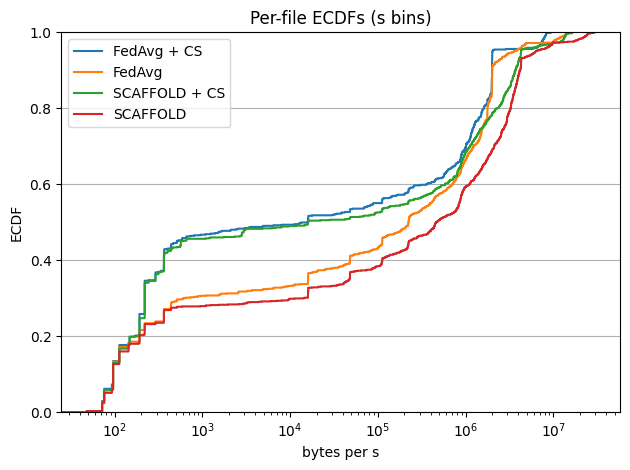

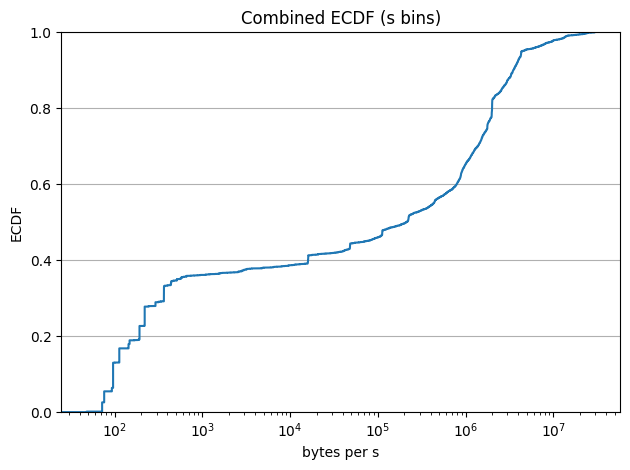

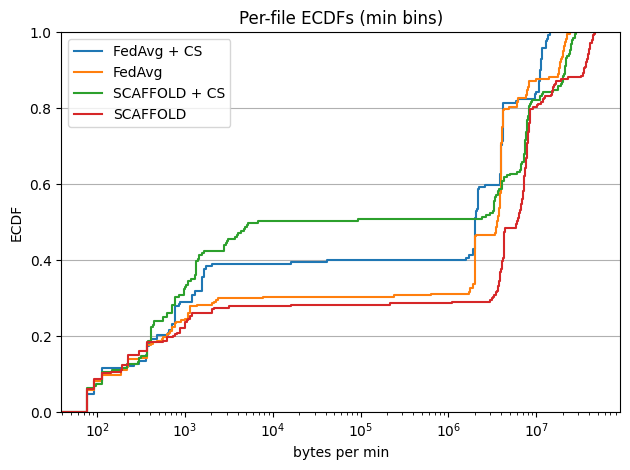

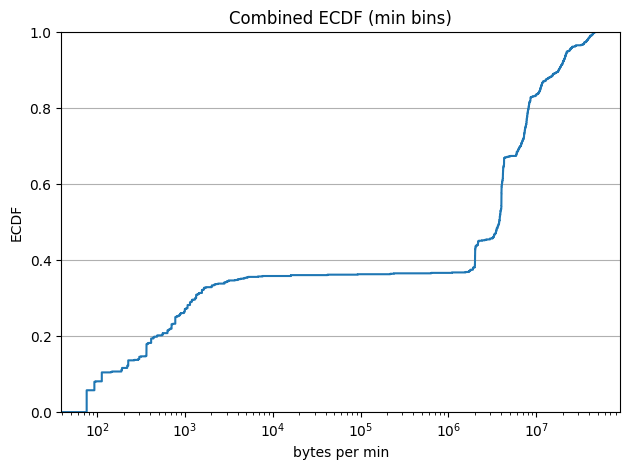

In [13]:
entries = [
    {'name': f'{d['model']}-{d['protocol']}-{d['client_selection']}-{d['data_distribution']}', 'df': pd.read_csv(d['pcap'])}
    for d in df_list_sync
]

entries = [e for e in entries if e['name'].split("-")[1] == "MQTT"]  # filter by protocol

entries_1 = [e for e in entries if e['name'].split("-")[2] == "False"]  # filter by client selection

entries = [e for e in entries if e['name'].split("-")[3] == "non"]  # filter by protocol



for entry in entries:
    parts = entry['name'].split('-')
    entry['name'] = parts[0] + (' + CS' if parts[2] == 'True' else '')

plot_multi_ecdf(entries, freq='s', combine=True)   # second-level
plot_multi_ecdf(entries, freq='min', combine=True)  # minute-level

# Async

In [14]:
# %%
import os, glob, re
from typing import Dict
import pyshark
import asyncio
import nest_asyncio
import pandas as pd
import pickle
from pathlib import Path

# Apply the patch
nest_asyncio.apply()

_ROUNDS_RE = re.compile(
    r"""
        Round\s+(\d+),\s+time\s+for\s+\S+\s+is\s+
        ([0-9]*\.?[0-9]+)
    """,
    re.VERBOSE,
)


# remove a trailing «-<letters+digits>»  (e.g. -eth0, -wlan1, -lo)
_IFACE_TAIL = re.compile(r"-[a-zA-Z]+[0-9]*$")


import os
import subprocess

def get_flow_stats(pcap_path: str) -> pd.DataFrame:
    """
    Ritorna un DataFrame aggregato per flusso (ip_src, ip_dst, bytes).
    Gestisce intestazioni con il punto (es. ip.src) rinominandole con _.
    """
    if not os.path.isfile(pcap_path):
        print(f"[warn] PCAP file not found: {pcap_path}")
        return pd.DataFrame(columns=["ip_src", "ip_dst", "bytes"])

    try:
        # 1. carica il CSV
        df = pd.read_csv(pcap_path, na_filter=False)        # mantieni stringhe vuote

        # 2. uniforma i nomi colonna: ip.src ➜ ip_src, ip.dst ➜ ip_dst
        df.columns = [c.replace(".", "_") for c in df.columns]

        required = {"ip_src", "ip_dst", "frame_len"}
        if not required.issubset(df.columns):
            raise ValueError(f"Mancano colonne: {required - set(df.columns)}")

        # 3. filtra solo traffico verso 10.0.0.100 da sorgenti diverse
        mask = (df["ip_dst"] == "10.0.0.100") & (df["ip_src"] != "10.0.0.100")
        df_filtered = df.loc[mask, ["ip_src", "ip_dst", "frame_len"]]

        # 4. aggrega per flusso e rinomina
        flows = (
            df_filtered.groupby(["ip_src", "ip_dst"], as_index=False)["frame_len"]
            .sum()
            .rename(columns={"frame_len": "bytes"})
        )
        return flows

    except Exception as e:
        print(f"[error] Failed to process PCAP {pcap_path}: {e}")
        return pd.DataFrame(columns=["ip_src", "ip_dst", "bytes"])

def _base_stem(path: str) -> str:
    """Stem without interface suffix."""
    stem = os.path.splitext(os.path.basename(path))[0]
    return _IFACE_TAIL.sub("", stem)

def _round_stats(log_path: str) -> tuple[int, int]:
    txt = open(log_path, encoding="utf-8").read()
    ids = [int(m.group(1)) for m in _ROUNDS_RE.finditer(txt)]
    return len(set(ids)), len(ids), ids

def analyze_federated_learning_data(folder: str) -> Dict[str, Dict]:
    pcaps = glob.glob(os.path.join(folder, "*ps_fed_opt0*.csv"))
    logs  = glob.glob(os.path.join(folder, "*ps_fed_opt0*.log"))

    # index logs by *base* stem
    logs_by_base = { _base_stem(p): p for p in logs }

    results = {}
    for pcap in pcaps:
        base = _base_stem(pcap)
        log  = logs_by_base.get(base)

        if log is None:
            print(f"[warn] n_msgsNo matching log for {pcap}")
            continue

        n_rounds, n_msgs,ids = _round_stats(log)
        dict_flow_B = get_flow_stats(pcap)

        results = {
            "rounds_completed": n_rounds,
            "client_messages":  n_msgs,
            "dict_flow_B": dict_flow_B,
            "ids": ids,
            "log": log,
            "pcap": pcap,
        }

    return results

# %%
base_path = "/home/antoniob/FederNet"

df_list_async = [
    {
    "file_path":"src/output/config_preliminary_test/2025-05-29-09-49-16_mqtt_fed_opt_C10_wifi_80211ac_rpi4_FedAsync_A10_CSFalse",
    "model":"FedAsync",
    "protocol":"MQTT",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
    "file_path":"src/output/config_preliminary_test/2025-05-29-19-24-39_mqtt_fed_opt_C10_wifi_80211ac_rpi4_Unweighted_A10_CSFalse",
    "model":"Unweighted",
    "protocol":"MQTT",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
    "file_path":"src/output/config_preliminary_test/2025-05-28-12-24-53_mqtt_fed_opt_C10_wifi_80211ac_rpi4_AsyncFedED_A10_CSFalse",
    "model":"AsyncFedED",
    "protocol":"MQTT",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
    "file_path":"src/output/config_preliminary_test/2025-05-28-22-02-23_mqtt_fed_opt_C10_wifi_80211ac_rpi4_ASOFed_A10_CSFalse",
    "model":"ASOFed",
    "protocol":"MQTT",
    "data_distribution":"iid",
    "client_selection":"False",
    # },{
    # "file_path":"src/output/config_mqtt_async/2025-06-18-11-24-49_mqtt_fed_opt_C10_wifi_80211ac_rpi4_FedAsync_A0.5_CSFalse",
    # "model":"FedAsync",
    # "protocol":"MQTT",
    # "data_distribution":"non-iid",
    # "client_selection":"False",
    # },{
    # "file_path":"src/output/config_mqtt_async/2025-06-18-17-07-30_mqtt_fed_opt_C10_wifi_80211ac_rpi4_Unweighted_A0.5_CSFalse",
    # "model":"Unweighted",
    # "protocol":"MQTT",
    # "data_distribution":"non-iid",
    # "client_selection":"False",
    # },{
    # "file_path":"src/output/config_mqtt_async/2025-06-18-19-56-29_mqtt_fed_opt_C10_wifi_80211ac_rpi4_AsyncFedED_A0.5_CSFalse",
    # "model":"AsyncFedED",
    # "protocol":"MQTT",
    # "data_distribution":"non-iid",
    # "client_selection":"False",
    },{ #grpc
    "file_path":"src/output/config_grpc/2025-06-09-07-41-30_grpc_fed_opt_C10_wifi_80211ac_rpi4_FedAsync_A10_CSFalse",
    "model":"FedAsync",
    "protocol":"gRPC",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
    "file_path":"src/output/config_grpc/2025-06-10-12-34-16_grpc_fed_opt_C10_wifi_80211ac_rpi4_Unweighted_A10_CSFalse",
    "model":"Unweighted",
    "protocol":"gRPC",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
        
    "file_path":"src/output/config_grpc/2025-06-10-10-54-39_grpc_fed_opt_C10_wifi_80211ac_rpi4_AsyncFedED_A10_CSFalse",
    "model":"AsyncFedED",
    "protocol":"gRPC",
    "data_distribution":"iid",
    "client_selection":"False",
    },{
    "file_path":"src/output/config_grpc/2025-06-08-04-45-03_grpc_fed_opt_C10_wifi_80211ac_rpi4_ASOFed_A10_CSFalse",
    "model":"ASOFed",
    "protocol":"gRPC",
    "data_distribution":"iid",
    "client_selection":"False",
    }
]


results_by_folder: Dict[str, Dict] = {}

for entry in df_list_async:
    full_path = os.path.join(base_path, entry["file_path"])
    entry["full_path"] = full_path

    flows_dict = analyze_federated_learning_data(full_path)  # <- usa get_flow_stats

            
            
    entry["flows"] = flows_dict['dict_flow_B']
    entry['rounds_details'] = flows_dict['ids']
    entry["rounds_completed"] = flows_dict['rounds_completed']
    entry["client_messages"] = flows_dict['client_messages']
    entry["log"] = flows_dict['log']
    entry["pcap"] = flows_dict['pcap']

    results_by_folder[entry["file_path"]] = entry
    
# ---------------------------------------------------------------------------
pkl_path = Path(base_path) / "sync_analysis.pkl"
with open(pkl_path, "wb") as fout:
    pickle.dump(df_list_async, fout)

print(f"[info] Analisi completata. Risultati salvati in: {pkl_path}")

for d in df_list_async:                     # each element is a dict-like record
    d['sum_bytes'] = d['flows']['bytes'].sum()
    d['per_round_bytes'] = d['sum_bytes'] / d['rounds_completed']
    d['per_message_bytes'] = d['sum_bytes'] / d['client_messages']
    d['overhead'] = d['per_message_bytes'] / 962628
    d['overhead_perc'] = (d['overhead'] -1)* 100

df = pd.DataFrame(df_list_async)

/tmp/ipykernel_3018242/2995938664.py:41: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(pcap_path, na_filter=False)        # mantieni stringhe vuote


[info] Analisi completata. Risultati salvati in: /home/antoniob/FederNet/sync_analysis.pkl


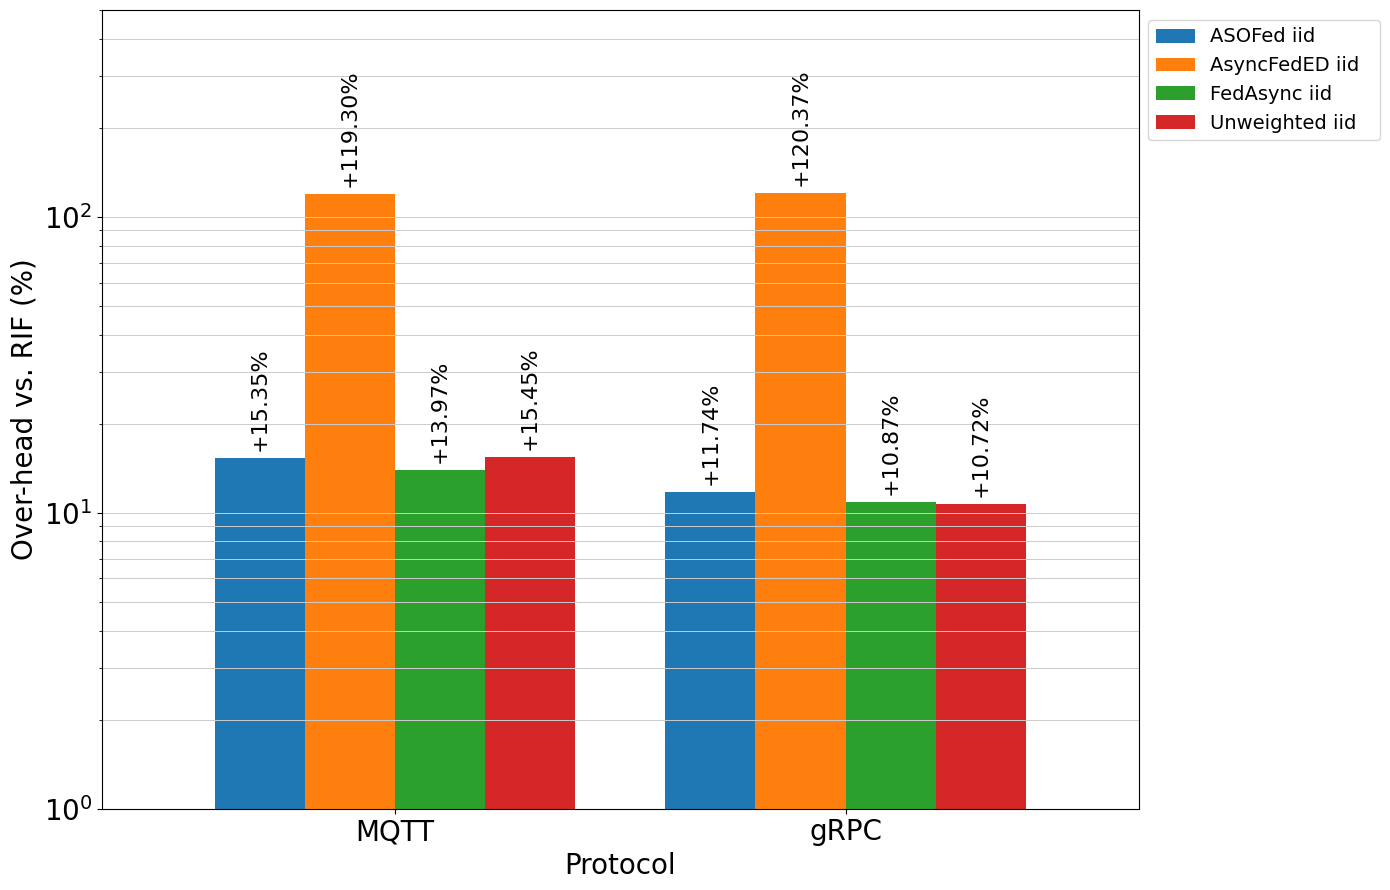

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# --------------------------------------------
# 1) sotto-bucket senza protocollo
# --------------------------------------------
df["subbucket"] = df.apply(
    lambda r: f"{r['model']} {r['data_distribution']} {'CS' if r['client_selection'] == 'True' else ''} ",
    axis=1
)

# --------------------------------------------
# 2) aggregazione e conversione in percentuale
#    (overhead fattoriale → delta %)
# --------------------------------------------
g = df.groupby(["protocol", "subbucket"])["overhead_perc"].mean()
# df_pct = (g - 1) * 100           # % rispetto al baseline
df_plot = g.unstack("subbucket")   # index = protocol, columns = subbucket

# --------------------------------------------
# 3) plot
# --------------------------------------------
fig, ax = plt.subplots(figsize=(14, 9))
bars = df_plot.plot(kind="bar", width=0.8, ax=ax)

# 3a) etichette + / - %
for container in bars.containers:
    labels = []
    for bar in container:
        v = bar.get_height()
        labels.append("" if np.isnan(v) else f"{'+' if v>=0 else ''}{v:.2f}%")
    ax.bar_label(container, labels=labels, label_type="edge",
                 fontsize=16, rotation=90, padding=5)

# 3b) asse Y symlog
ax.set_yscale("log")   # segmento lineare entro ±1 %
ax.set_ylim(1, 500)   
minor_ticks = [-50,-40,-30,-20,-10,-9,-8,-7,-6,-5,-4,-3,-2,
               2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90,
               100,200,300,400,500,600,700,800,900]
ax.yaxis.set_minor_locator(FixedLocator(minor_ticks))

# 3c) estetica
plt.grid(axis="y", which="both", color="#cccccc", linestyle="-", linewidth=0.7)
plt.xticks(rotation=0, fontsize=20)      # i tick contengono già solo il protocollo
plt.yticks(fontsize=20)
plt.xlabel("Protocol", fontsize=20)
plt.ylabel("Over-head vs. RIF (%)", fontsize=20)

plt.legend(loc="upper left", bbox_to_anchor=(1, 1),
           fontsize=14, title="")        # solo sub-bucket
plt.tight_layout()
plt.show()


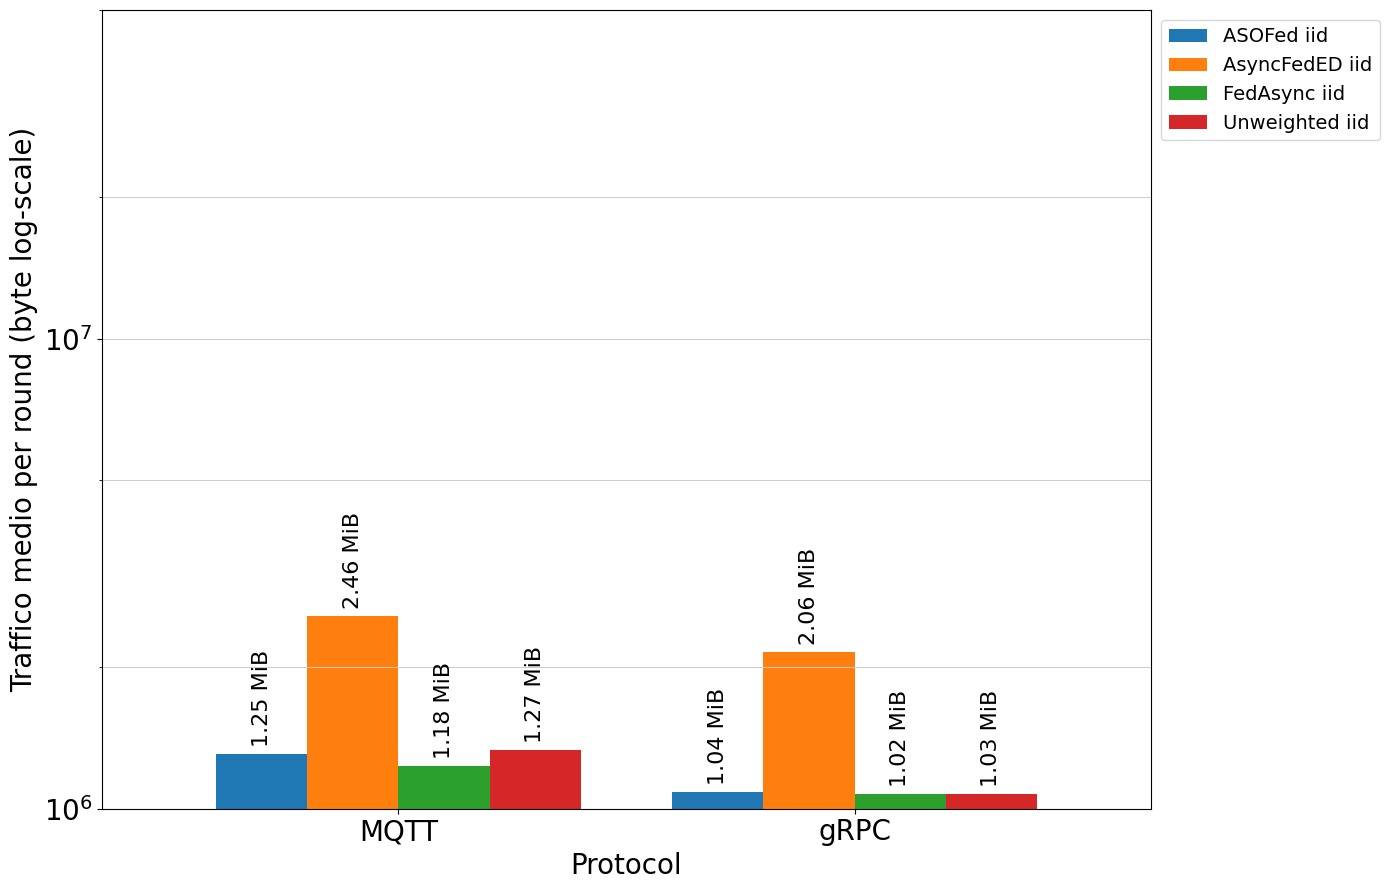

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# ------------------------------------------------------------------
# 1) sotto-bucket (senza protocollo nella stringa)
# ------------------------------------------------------------------
df["subbucket"] = (
    df.apply(
        lambda r: f"{r['model']} {r['data_distribution']} "
                  f"{'CS' if r['client_selection'] == 'True' else ''}".strip(),
        axis=1
    )
)

# ------------------------------------------------------------------
# 2) aggregazione (media per protocollo+sotto-bucket)
# ------------------------------------------------------------------
g = df.groupby(["protocol", "subbucket"])["per_round_bytes"].mean()
df_plot = g.unstack("subbucket")      # index = protocol, columns = subbucket

# ------------------------------------------------------------------
# 3) plot
# ------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(14, 9))
bars = df_plot.plot(kind="bar", width=0.8, ax=ax)

# ──────────────────────────────────────────────────────────────────
# 3a) etichette in B / KiB / MiB
# ──────────────────────────────────────────────────────────────────
def fmt_bytes(b):
    if np.isnan(b):
        return ""
    if b >= 1024**2:
        return f"{b/1024**2:.2f} MiB"
    if b >= 1024:
        return f"{b/1024:.2f} KiB"
    return f"{b:.0f} B"

for container in bars.containers:
    ax.bar_label(
        container,
        labels=[fmt_bytes(bar.get_height()) for bar in container],
        label_type="edge",
        fontsize=16,
        rotation=90,
        padding=5
    )

# ──────────────────────────────────────────────────────────────────
# 3b) asse Y symlog (byte)
# ──────────────────────────────────────────────────────────────────
ax.set_yscale("log")
ax.set_ylim(1_000_000, 50_000_000)      # (≈ 10 KB – 100 MB)
minor_ticks = [
    20_000, 50_000, 100_000, 200_000, 500_000,           # KiB region
    1_000_000, 2_000_000, 5_000_000,                     # MiB region
    10_000_000, 20_000_000, 50_000_000
]
ax.yaxis.set_minor_locator(FixedLocator(minor_ticks))

# ──────────────────────────────────────────────────────────────────
# 3c) estetica
# ──────────────────────────────────────────────────────────────────
plt.grid(axis="y", which="both", color="#cccccc", linestyle="-", linewidth=0.7)
plt.xticks(rotation=0, fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Protocol", fontsize=20)
plt.ylabel("Traffico medio per round (byte log-scale)", fontsize=20)

plt.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1),
    fontsize=14,
    title=""                      # mostra solo il sub-bucket
)
plt.tight_layout()
plt.show()


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

def aggregate_bytes(df: pd.DataFrame, freq: str = '1S') -> pd.Series:
    """
    Aggregate `frame.len` into fixed-width time bins.

    Parameters
    ----------
    df   : DataFrame must contain columns
           • frame.time_epoch (float, Unix time)  
           • frame.len (int, bytes)
    freq : str, default '1S'
           Any pandas offset alias:
             ▸ '1S'  → every second  
             ▸ '1T'  → every minute  
             ▸ '15T' → 15-minute bins, etc.

    Returns
    -------
    Series indexed by bin-start timestamp with summed bytes.
    """
    # convert epoch → datetime index
    ts = pd.to_datetime(df['frame.time_epoch'], unit='s', origin='unix')
    g  = df.assign(ts=ts).set_index('ts')['frame.len']

    # fixed-width roll-up
    return g.resample(freq).sum()



def plot_ecdf_from_series(series: pd.Series, label: str):
    sns.ecdfplot(series.to_numpy(), stat='proportion', label=label)
    
def plot_multi_ecdf(entries, freq='1S', combine=False):
    """
    entries : list[{ 'name': str, 'df': DataFrame }]
    freq    : aggregation step, e.g. '1S' or '1T'
    """
    plt.figure()
    all_vals = []

    for e in entries:
        agg = aggregate_bytes(e['df'], freq)
        vals = agg[agg > 0]          # drop empty bins, keep >0 if desired
        all_vals.append(vals)
        sns.ecdfplot(vals, stat='proportion', label=e['name'])

    plt.xlabel(f'bytes per {freq}')
    plt.ylabel('ECDF')
    plt.title(f'Per-file ECDFs ({freq} bins)')
    plt.legend(); plt.grid(True, axis='y'); plt.tight_layout()

    if combine:
        plt.figure()
        sns.ecdfplot(pd.concat(all_vals).to_numpy(), stat='proportion')
        plt.xlabel(f'bytes per {freq}')
        plt.ylabel('ECDF')
        plt.title(f'Combined ECDF ({freq} bins)')
        plt.grid(True, axis='y'); plt.tight_layout()


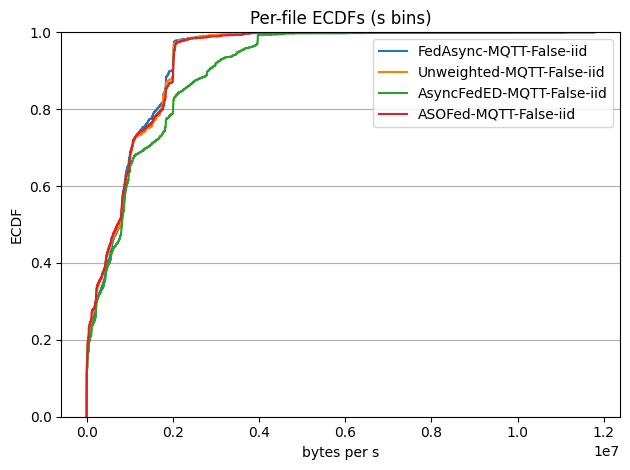

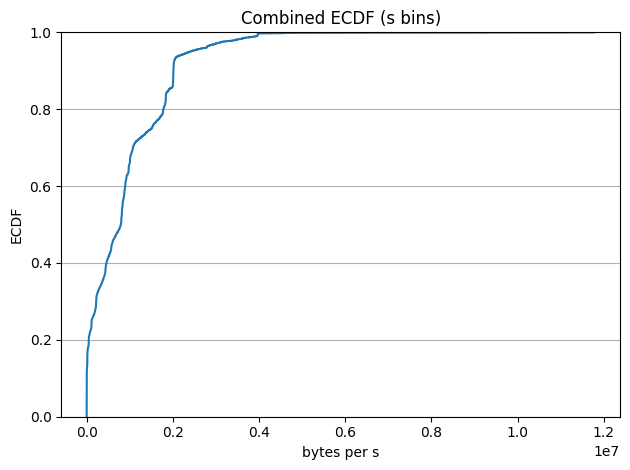

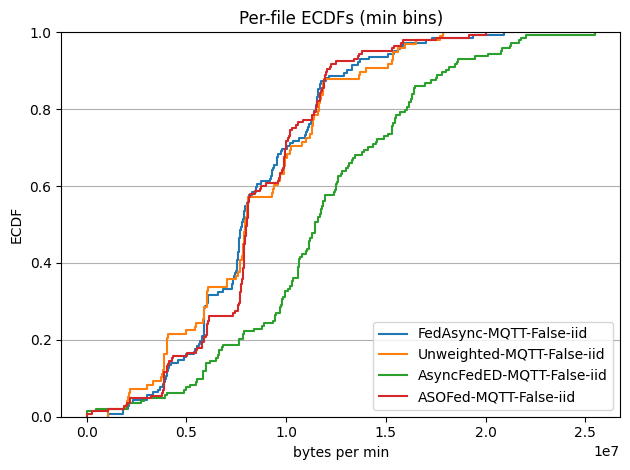

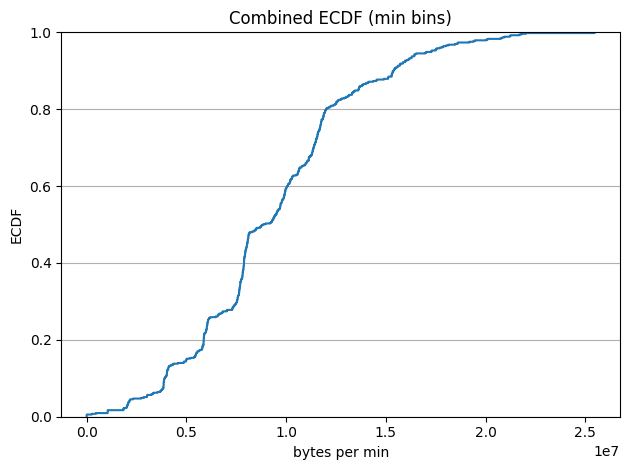

In [18]:
entries_async = [
    {'name': f'{d['model']}-{d['protocol']}-{d['client_selection']}-{d['data_distribution']}', 'df': pd.read_csv(d['pcap'])}
    for d in df_list_async
]

entries_async = [e for e in entries_async if e['name'].split("-")[1] == "MQTT"]





plot_multi_ecdf(entries_async, freq='s', combine=True)   # second-level
plot_multi_ecdf(entries_async, freq='min', combine=True)  # minute-level

In [19]:
def compare_combined_ecdf(entries_sync, entries_async, freq='1S'):
    """
    Compare combined ECDFs between synchronous and asynchronous entries.
    
    Parameters
    ----------
    entries_sync : list of dicts with 'name' and 'df' keys for synchronous data
    entries_async : list of dicts with 'name' and 'df' keys for asynchronous data
    freq : str, default='1S'
           Time bin frequency (e.g., '1S' for seconds, '1T' for minutes)
    """
    plt.figure(figsize=(12, 8))
    
    # Process synchronous entries
    sync_vals = []
    for e in entries_sync:
        agg = aggregate_bytes(e['df'], freq)
        vals = agg[agg > 0]  # drop empty bins
        sync_vals.append(vals)
    
    # Process asynchronous entries
    async_vals = []
    for e in entries_async:
        agg = aggregate_bytes(e['df'], freq)
        vals = agg[agg > 0]  # drop empty bins
        async_vals.append(vals)
    
    # Plot combined ECDFs
    if sync_vals:
        sns.ecdfplot(pd.concat(sync_vals).to_numpy(), stat='proportion', 
                     label=f'Synchronous ({len(entries_sync)} experiments)', 
                     linewidth=3)
    
    if async_vals:
        sns.ecdfplot(pd.concat(async_vals).to_numpy(), stat='proportion', 
                     label=f'Asynchronous ({len(entries_async)} experiments)', 
                     linewidth=3, linestyle='--')
    
    # Styling
    plt.xlabel(f'Bytes per {freq}', fontsize=14)
    plt.ylabel('ECDF', fontsize=14)
    plt.title(f'Comparison: Sync vs Async Communication Patterns ({freq} bins)', fontsize=16)
    plt.grid(True, axis='both', alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    
    # Add a log scale plot to better visualize the tail
    plt.figure(figsize=(12, 8))
    
    if sync_vals:
        sns.ecdfplot(pd.concat(sync_vals).to_numpy(), stat='proportion', 
                     label=f'Synchronous ({len(entries_sync)} experiments)', 
                     linewidth=3)
    
    if async_vals:
        sns.ecdfplot(pd.concat(async_vals).to_numpy(), stat='proportion', 
                     label=f'Asynchronous ({len(entries_async)} experiments)', 
                     linewidth=3, linestyle='--')
    
    plt.xscale('log')
    plt.xlabel(f'Bytes per {freq} (log scale)', fontsize=14)
    plt.ylabel('ECDF', fontsize=14)
    plt.title(f'Comparison: Sync vs Async Communication Patterns ({freq} bins, log scale)', fontsize=16)
    plt.grid(True, axis='both', alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()

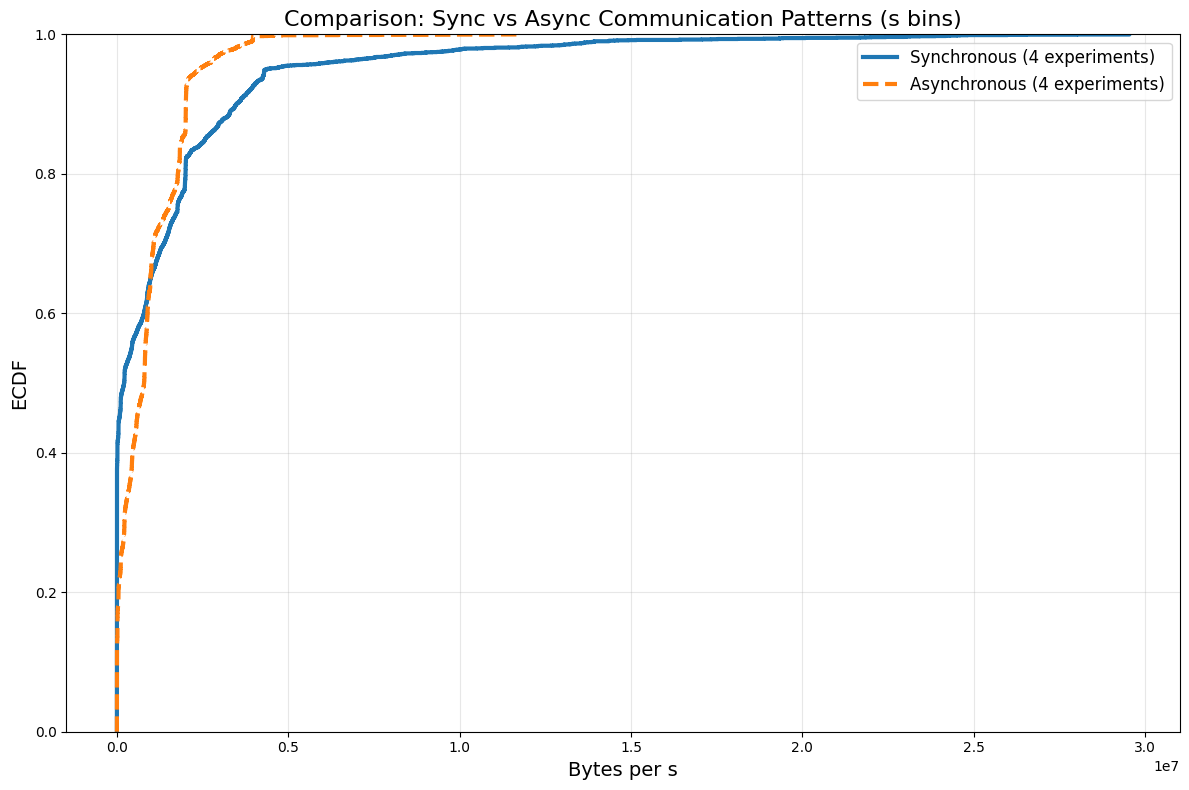

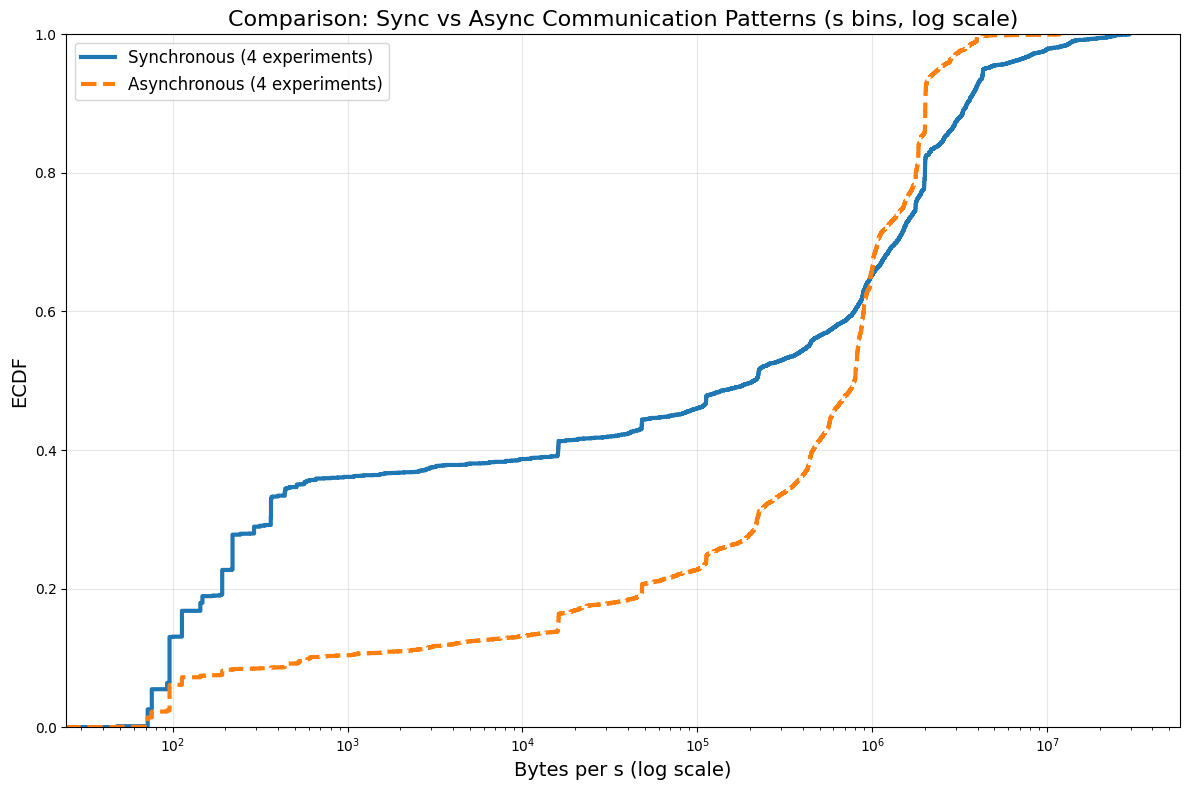

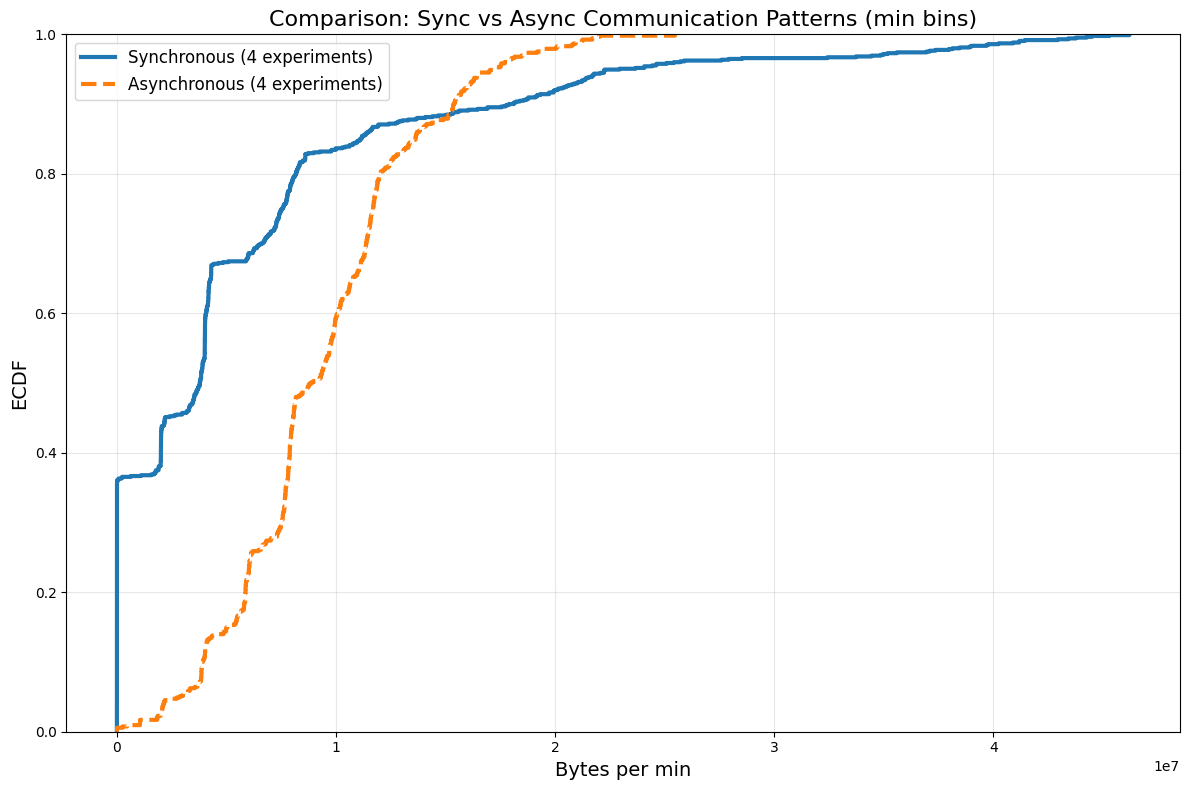

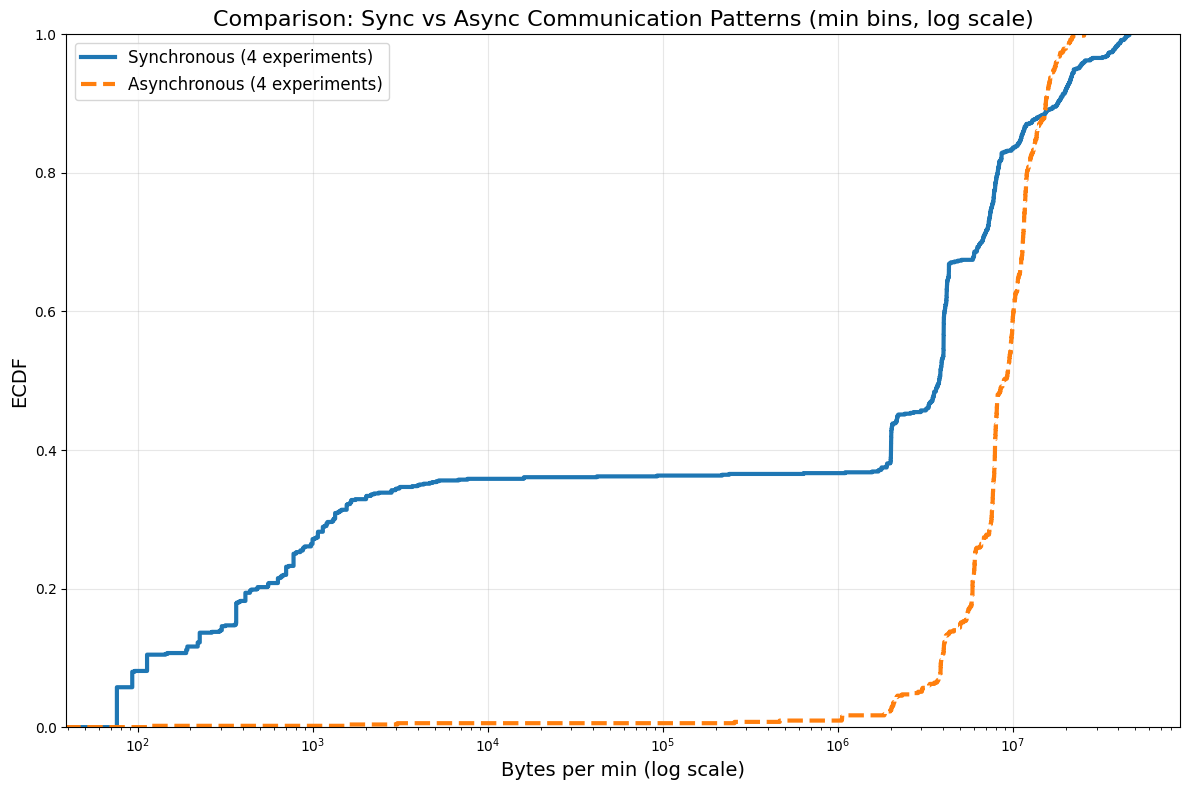

In [20]:
# Compare sync and async at different time scales
compare_combined_ecdf(entries, entries_async, freq='s')  # second-level
compare_combined_ecdf(entries, entries_async, freq='min')  # minute-level

#READ MEEEEE

#TODO Reformat Plot
# Why async when removed # entries_async = [e for e in entries_async if e['name'].split("-")[1] == "MQTT"] behave stangely, grpc are wrong and that is fine, but why we have this big difference async should be as now but when removed grpc it behaves the opposit all the alg have a datarate ohiger, maybe the algorithm to compute the fre is wrong
